#### **Model project: A Solow model with fossil fuels and a climate externality**

The motivation for this project is to analyze long-term growth in th presence of finite resources and a negative externality from previously utilized ressources. For this purpose, we analyze the following Solow model:

**Model setup** <br>
Equations (1)-(7) below charicterize a Solow model for a closed economy with depletable fossil , fuels. The stock of fossil fuels is denoted by $R_r$ and $E_t$ is the ammount of fossil fuels used as an input in production in each period. $Y_t$ denotes GDP and $K_t, L_t$ and $A_t$ denotes Capital, labor and total factor productivity (TFP), respectively. Equations (3) describes capital accumulation, equation (4) and (5) decribes the evolution of the stock of labour and TFP, respectively.

:
\begin{equation}
    Y = D_t \cdot K^{\alpha}_{t} (A_t L_t)^\beta E^\epsilon_t, \quad \alpha, \beta, \epsilon > 0 \quad \alpha + \beta +\epsilon = 1 \tag{1}
\end{equation}
\begin{equation}
    D_t = \left( \frac{R_t}{R_0} \right) ^\phi, \quad \phi > 0 \tag{2}
\end{equation} 
\begin{equation}
    K_{t+1} = sY_t +(1-\delta)K_t, \quad 0 < \delta < 1 \tag{3}
\end{equation}
\begin{equation}
     L_{t+1} = (1+n)L_t, \quad  n \geq 0  \tag{4}
\end{equation}
\begin{equation}
     A_{t+1} = (1+g)A_t, \quad  g \geq 0 \tag{5}
\end{equation}
\begin{equation}
     R_{t+1} = R_t - E_t \tag{6}
\end{equation}
\begin{equation}
     E_{t} = s_E R_t, \quad  0  < s_E  < \delta \tag{7}
\end{equation}

**Loading packages**

In [1]:
import numpy as np
from scipy import linalg
from scipy import optimize as opt
from scipy.ndimage.interpolation import shift
import sympy as sm
import pandas as pd
import matplotlib.pyplot as plt
sm.init_printing(pretty_print = True)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.animation as animation
from matplotlib.widgets import Slider


**Climate externality** 

The following graph maps the damage function of the climate externality for different values of the $\phi$, i.e. the parameter that determines the marginal damage that the externality inflcits. As we will see, the nature of the loss functio is critical for whether climate change will affect long term growth. 
\begin{equation}
D_t = \left(  \frac{R_t}{R_0} \right) ^\phi , \qquad \phi  > 0  \tag{Externality}
\end{equation}
For $\phi>1$ the marginal damage caused by the cumulcative use of fossil fuels will be decreasing and for $1>\phi>0$ the marginal damage will be increasing.

In [2]:
    # The following figure shoes the transition of the damage function as fossil fuels are being depleated. 
   
    def Damage_function(R0,RT,phi):
        D = (RT/R0)**phi;                
        return D

    def plot_func(phi):
        R0 = 100; 
        R_series = np.linspace(0.1,R0,100)
        D_series = np.zeros(100)

        for i in range(0,100):
            D_series[i] = Damage_function(R0, R_series[i],phi)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title("Transition of $D_t$ for different values of phi")
        ax.set_xlabel('$R_T$ - stock left')
        ax.set_ylabel('Damage function')
        ax.set_xlim([0, 100])
        ax.set_ylim([0, 1])   
        x1 = np.linspace(*ax.get_xlim())
        x2 = np.linspace(*ax.get_ylim())
        ax.plot(x1, x2, 'k--')
        ax.plot(R_series,D_series,'b')

    interact(plot_func, phi = widgets.FloatSlider(Value=1, min=0.05, max=4, step=0.05))    

interactive(children=(FloatSlider(value=0.05, description='phi', max=4.0, min=0.05, step=0.05), Output()), _do…

<function __main__.plot_func(phi)>

**Production function** <br>
The following function defines the Cobb-Douglas production function with the multiplicative damage function.
We rewrite (1) using $E_t = s_E \cdot R_T$ and the defition of $D_t$:

$$Y_t = R_t^{\phi + \epsilon} R_0^{-\phi} s_E^\epsilon K^{\alpha}_{t} (A_t L_t)^\beta$$ 

In [3]:
# Production function
def production(R,R0,A,L,K,phi,epsilon,se, beta, alpha):
    Y = R**(phi + epsilon) * R0 **(-phi) * se**epsilon * (A*L)**beta * K**alpha
    return Y

In [4]:
# Analytical long run steady state level growth rate for plotting 
def gy_ss(beta,epsilon,g,n,phi,se):
    g_ss = g*beta/(beta+epsilon) -n*epsilon/(beta+epsilon) -se*(epsilon+phi)/(beta+epsilon)
    return g_ss

**Simulating the model** <br>
We simulate the model from time $t=1$ up to time $T=200$ which is abitrarily chosen, in a recursive fashion. The variables $R_t$, $A_t$ and $L_t$ grows exogeneously, output in the current period is given by current values $Y_t = F(K_t,L_t,A_t,R_T)$, but the next period kapital level $K_{t+1} = sY_t +(1-\delta)K_t $ grows in a recursive fashion. We need to initialize the series at index [0] given this feature. We simulate the economy this way and plot the output/labor ratios and kapital/labor ratios.

In [5]:
#Parameter values
alpha = 0.2
beta = 0.6
epsilon = 1-alpha -beta
s = 0.2
se = 0.005
g = 0.02
n = 0.02
phi = 0.8
delta = 0.08

#Starting values for state varaibles
K0 = 10
R0 = 10
L0 = 10
A0 = 10

# Empty vectors for storring result
K_list = []
R_list = []
A_list = []
L_list = []
Y_list = []

# Initialize 
K_list.append(K0)
R_list.append(R0)
A_list.append(A0)
L_list.append(L0)
Y_list.append(production(R0,R0,A0,L0,K0,phi,epsilon,se, beta,alpha)) 

T = 200; 

t = 1
while t <= T:
    K_list.append(s*Y_list[t-1] + (1-delta)*K_list[t-1])
    R_list.append(R_list[t-1]*(1-se))
    A_list.append(A_list[t-1]*(1+g))
    L_list.append(L_list[t-1]*(1+n))
    Y_list.append(production(R_list[t],R0,A_list[t],L_list[t],K_list[t],phi,epsilon,se, beta,alpha))
    t += 1

Y_list = np.array(Y_list) # To numpy array
L_list = np.array(L_list) # To numpy array
K_list = np.array(K_list) # To numpy array 

# Per units of labor 
y_list = Y_list/L_list  # Element wise division 
k_list = K_list/L_list


Y_max = np.max(Y_list)
K_max = np.max(K_list)

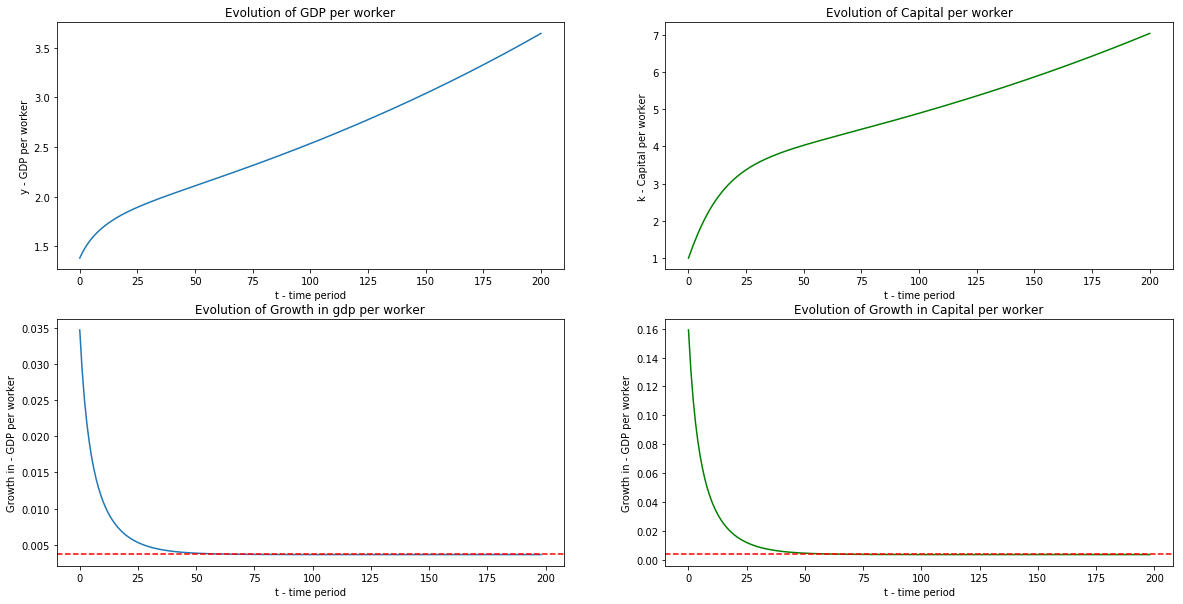

In [6]:
# Growth rate 
y_list_lagged = np.roll(y_list,1)
k_list_lagged = np.roll(k_list,1)
k_growth = np.log(k_list[1:200]) - np.log(k_list_lagged[1:200])
y_growth = np.log(y_list[1:200]) - np.log(y_list_lagged[1:200])
g_ss=gy_ss(beta,epsilon,g,n,phi,se) # steady state growth rate

#Plot
f = plt.figure()
# first subplot

f.set_figheight(10)
f.set_figwidth(20)

plt.subplot(2,2,1)
plt.plot(y_list)
plt.ylabel('y - GDP per worker')
plt.xlabel('t - time period')
plt.title('Evolution of GDP per worker')

plt.subplot(2,2,2)
plt.plot(k_list, color = 'g')
plt.ylabel('k - Capital per worker')
plt.xlabel('t - time period')
plt.title('Evolution of Capital per worker')

plt.subplot(2,2,3)
plt.plot(y_growth)
plt.axhline(g_ss, color='r', linestyle='--')
plt.ylabel('Growth in - GDP per worker')
plt.xlabel('t - time period')
plt.title('Evolution of Growth in gdp per worker')

plt.subplot(2,2,4)
plt.plot(k_growth, color = 'g')
plt.axhline(g_ss, color='r', linestyle='--')
plt.ylabel('Growth in - GDP per worker')
plt.xlabel('t - time period')
plt.title('Evolution of Growth in Capital per worker')

plt.show()

From the graphs above we notice there is possitive growth in GDP pr. worker and Capital pr. worker even in the long run. This seems at firsthand rather counter intuitive: How can one manage to obtained sustained growth in the long run, when we exhaust a non-renewable ressource which is essential for production. This is a result of perfect substitution between the inputs of manmade capital and natural ressources. As time passes we will substitute towards using less natural ressources and more manmade capital in production, and in the limit we use an infinitesimal amount of the natural ressource. It should be noted the assumption of perfect substitution between these inputs have been critized by prominent economist as HERMAN E. DALY (1990) who argues against neoclassical production functions "... Do extra sawmills substitute for diminishing forests? Do more refineries substitute for depleted oil wells? Do larger nets substitute for declining fish populations?". 

Additional it is noticeable that the growth rate in capital per worker and growth rate in gdp per worker, converges to the same level in the long run. From this we suggest there must exist some level of capital/ output ratio which is constant in a steady state level. In the following we examing this.

**Finding the steady-state**

In the last section we established that the growth rate of capital and output was identical in the long run. If we define capital/ output ratio $z_t \equiv \frac{K_t}{Y_t} = \frac{k_t}{y_t}$, we are now interested in determining the steady of this ratio. Straight forward algebra of the model equations gives us the following transition equation:

$z_{t+1} = \left( \frac{1}{1-s_e}\right)^{\epsilon + \phi}\left(\frac{1}{(1+n)(1+g)}\right)^{\beta}(s+(1-\delta)z_{t})^{1-\alpha}z_{t}^{\alpha}$

The steady state value is characterized by $z_{t} = z_{t+1} = z_{ss}$ or equivalently the growth rate of $z$ $g_z = 0$.

**Numerical solution of the capital output ratio, $z_t$**

To find the steady state numerically, we try different numerical methods. We consider the Newton algorithm which is gradient based, the bisection method and the brentq method, which combines a bisection medthod along with other optimization procedures. We simply use numerical derivatives for the newton algorithm, but one could consider for simple problems of passing analytical gradient and hessian. Concerning the bisection method and the brentq (who combines this method), we need to pass an interval in which to find the root. WE have used different optimization methods with the same same tolerance level for all the algorithms.

In [7]:
# Solve for ss 
#Parameter values
alpha = 0.2
beta = 0.6
epsilon = 1-alpha -beta
s = 0.2
se = 0.005
g = 0.02
n = 0.02
phi = 0.8
delta = 0.08

def helpfun(se, eps, phi, n, g, beta):
    frac = (1/(1-se))**(epsilon + phi) * (1/((1+n)*(1+g)))**beta 
    return (frac)

power_alpha = lambda z: z**alpha
depsav = lambda z: (s + (1-delta)*z)**(1-alpha)
Obj_ss = lambda zss: zss - helpfun(se, epsilon, phi, n, g, beta)*depsav(zss)*power_alpha(zss)

# Newton Method
z_start = 0.2;
zss_newton = opt.newton(Obj_ss, z_start, tol = 1.48e-08, rtol=4.5e-9, maxiter=100,
                        full_output=True, disp=True)
# Bisection
zmin = 0.001
zmax = 2
zss_bisect = opt.bisect(Obj_ss, zmin, zmax,args=(), xtol=1.48e-08,
                    rtol=4.5e-9, maxiter=100,
                    full_output=True, disp=True)
# Brent - q
zss_brentq = opt.brentq(Obj_ss, zmin, zmax,
                    args=(), xtol=1.48e-08,
                    rtol=4.5e-9, maxiter=100,
                    full_output=True, disp=True)
print(zss_newton)
print(zss_bisect)
print(zss_brentq)
# Brentq method
result = opt.root_scalar(Obj_ss,bracket=[0.01,10], method = 'brentq')

(1.92835954580555,       converged: True
           flag: 'converged'
 function_calls: 7
     iterations: 6
           root: 1.92835954580555)
(1.9283595391735433,       converged: True
           flag: 'converged'
 function_calls: 29
     iterations: 27
           root: 1.9283595391735433)
(1.9283595458055507,       converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 1.9283595458055507)


From the results we notice all 3 root-findings method converge to the same result (within an appropriate number of decimals). There is big difference in how fast the algorithms converge. The newton- and qbrent method approximately converge at the same speed the bisection method use a vastly higher amount of iterations to converge. In this application the "brent-q" method seems the fastest, but this may also be a result of starting values and interval size etc.

**Solving the model symbolcally using the sympy packages**

In the following we solve the steady state symbolically, by the sympy package. We had to "help" with some of the derivations for it to work.

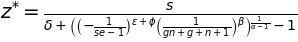

In [8]:
z = sm.symbols('k')
se = sm.symbols('se')
epsilon = sm.symbols('epsilon')
phi = sm.symbols('phi')
beta = sm.symbols('beta')
n = sm.symbols('n')
g = sm.symbols('g')
s = sm.symbols('s')
delta = sm.symbols('delta')
alpha = sm.symbols('alpha')
                   

# write your code here
frag = 1/((1 + n)*(1 + g)) # Fraction 
V = ((1/(1-se))**(phi + epsilon)) * frag**beta # Terms which does not depend on z


steadystate = sm.Eq(V**(1/(1-alpha)) * (s + (1-delta)*z),z)
zss = sm.solve(steadystate,z)[0]
z = sm.symbols('z^*')
zequation = sm.Eq(z,zss)
zequation

This expression looks somewhat similar as the analytical expression for the model, we will compare it numerically later.   

In [9]:
# We save python function
z_ss_func = sm.lambdify((s,epsilon,se,n,g,phi,beta,delta,alpha),zss) # Steady state value 

We will compare these results to the analytical solution: 
$$z^*=\frac{s}{(1-s_E)^{\frac{\epsilon+\phi}{\beta+\epsilon}}[(1+n)(1+g)]^\frac{\beta}{\beta+\epsilon}-(1-\delta)} >0$$


In [10]:
# Analytical solution and comparing all the results
    
alpha = 0.2
beta = 0.6
epsilon = 1-alpha -beta
s = 0.2
se = 0.005
g = 0.02
n = 0.02
phi = 0.8
delta = 0.08

def z_ss_analytical(s, se, epsilon, phi, n, g, beta, alpha, delta):
    denominator = (1-se)**((epsilon+phi)/(beta+epsilon))*((1+n)*(1+g))**(beta/(beta + epsilon)) - (1-delta)
    z_ss = s/denominator
    return(z_ss)

z_ss_analytical = z_ss_analytical(s,se, epsilon, phi, n, g, beta, alpha, delta)
z_ss_sm = z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha)
z_num = zss_brentq
print(f'''The steady-state value using the analytical expression is {z_ss_analytical:.4f}, 
    The steady-state value using the sympy derieved expression is {z_ss_sm:.4f},
    The steady-state value using numerical methods is {z_num[0]:.4f}''')


The steady-state value using the analytical expression is 1.9284, 
    The steady-state value using the sympy derieved expression is 1.9284,
    The steady-state value using numerical methods is 1.9284


Both our "sympy" and numerical methods gives the same result as the analytical solution. This shows that the solution derived by sympy was the correct solution. 

**Plotting the transition diagram**

In order to plot the transition diagram we need the values for $z_t$ and $z_{t+1}$, respectively. Steady state is found where $z_t = z_{t+1}$ and thus where the curve intersects the 45 degree line. 

We start out by defining a function for the transition equation.

In [11]:
def z_next_func(s,epsilon,se,n,g,phi,beta,delta,alpha,x):
    z = (1/(1-se))**(epsilon+phi)*(1/((1+n)*(1+g)))**beta*(s+(1-delta)*x)**(1-alpha)*x**alpha
    return z

In [12]:
# Create a for loop to calculate the values of the transition equation in all T=200 periods.   
x = np.zeros((T,1))
x[0] = 0.00
for t in range(0,T-1):
    x[t+1] = z_next_func(s,epsilon,se,n,g,phi,beta,delta,alpha,x[t])

# Define the function "transition()" in order to create figure with the transition diagram
# and make it possible to create float sliders for specific variables. 

def transition(s,epsilon,se,n,g,phi,beta,delta,alpha): 
    zmin = 0.0 
    zmax = z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha)*1.2

    z_set = np.linspace(zmin, zmax,100)
    fig1 = plt.figure(figsize=(6.5,5),facecolor = 'white')
    plt.plot(z_set,z_next_func(s,epsilon,se,n,g,phi,beta,delta,alpha,z_set),'k-', #transition function
             z_set, z_set, 'r--',  #45 degree line
             z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha), z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha), 'ko', #st.st. point
            (z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha), z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha)),
            (z_ss_func(s,epsilon,se,n,g,phi,beta,delta,alpha),0),'k--') # Vertical dashed line at st.st.
    plt.ylim(bottom=0) #let plot start at z_(t+1) = 0
    plt.xlim(left=0) #let plot start at z_t = 0
    plt.xlabel('$z_t$')
    plt.ylabel('$z_{t+1}$')
    plt.title('Transition diagram for the capital output ratio, $z_t$')
    plt.show(fig1)


# Create float sliders     
widgets.interact(transition,
                 s = widgets.FloatSlider(description='$s$',min=0, max=1, step=0.01, value=0.20),
                 epsilon = widgets.fixed(epsilon),
                 beta = widgets.fixed(beta),
                 alpha = widgets.fixed(alpha),
                 se = widgets.FloatSlider(description='$s_{E}$', min=0, max=0.01, step=0.001, value=0.005),
                 n = widgets.FloatSlider(description='$n$', min=0, max=1, step=0.001, value=0.01),
                 g = widgets.FloatSlider(description='$g$', min=0, max=1, step=0.001, value=0.02),
                 phi = widgets.FloatSlider(description='$\phi$', min=0, max=5, step=0.1, value=2),
                 delta = widgets.fixed(delta)
                )

interactive(children=(FloatSlider(value=0.2, description='$s$', max=1.0, step=0.01), FloatSlider(value=0.005, …

<function __main__.transition(s, epsilon, se, n, g, phi, beta, delta, alpha)>

**An increase in the savings rate:** Capital accumulation increases which leads to an increase in both capital and output. The effect of an increase in the savings rate is greater with respect to capital, however. This is due to the (highly plausable) assumption that the output elasticity with respect to capital is less than 1. Hence, an increase in the savings rate increases the capital/output ratio in steady state.   
**An increase in $s_E$:** An increase in $s_E$ increases the steady state value of the capital/output ratio. An increase in $s_E$ means that a greater fraction of the remaining stock of fossil fuels is used each period. Initially this increases production through an increase in energy input.
<br>**An increase in n:** An increase in population growth lowers the steady state value.  
*An increase in g:* An increase in technology growth lowers the steady state value of the capital output ratio. This follows from the fact that less capital is needed in order to produce a given amount of output. 
<br>**An increase in $\phi$:** An increase in $\phi$ increases the steady state value of $z$.

**New damage function and the prospect of long-term growth** <br>
Untill now it have been possible to have long term growth in the output labor ratio and the kapital labor ratio. Thus, we have been able to find a steady state capital output ratio $z_{ss}$. Now, we alter the damage function and introduce a parameter $\bar \rho $. This parameter reflects a "tipping point" in the damage function: when this point is surpassed production will halt completely! Formaly we define:

\begin{equation}
D_t = \left( \frac{ \left( \frac{R_t}{R_0}\right) - \bar \rho }{1-\bar \rho} \right) ^\phi , \qquad \phi  > 0 \qquad  0<\bar \rho < 1
\end{equation}

with $\bar \rho R_t \leq R_t \leq R_0$.

In [19]:
## Second damage function

def Damagefunc2(R0,RT,phi,rho):
    D = (((RT/R0)-rho)/(1-rho))**phi                
    return (D)

def plot_func(phi,rho):
        R0 = 100;
        R_series = np.linspace(R0*rho,R0,100)
        D_series = np.zeros(100)

        for i in range(0,100):
            D_series[i] = Damagefunc2(R0, R_series[i],phi,rho)

        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title("Transition of $D_t$ for different values of phi")
        ax.set_xlabel('$R_T$ - stock left')
        ax.set_ylabel('Damage function')
        ax.set_xlim([0, 100])
        ax.set_ylim([0, 1])   
        x1 = np.linspace(*ax.get_xlim())
        x2 = np.linspace(*ax.get_ylim())
        ax.plot(R_series,D_series,'b')

interact(plot_func, phi = widgets.FloatSlider(Value=1, min=0.05, max=4, step=0.05), rho = widgets.FloatSlider(Value=2, min=0.1, max=1, step=0.05))

interactive(children=(FloatSlider(value=0.05, description='phi', max=4.0, min=0.05, step=0.05), FloatSlider(va…

<function __main__.plot_func(phi, rho)>

 The figure illustrates that the prospect of long-term growth is higly dependent on the nature of the climate externality. In the first case, long-term growth was possible even though the value of the damage function converges to zero. Growth was possible because output tended to infinity as $D_t$ tenden to zero. In the seconde case, however, the tipping point means that the damage function becomes zero at a certain year and 

**Concluding remarks**

In this project we have investigated how incorporating fossil fuels and an associated damage function alters the classic results from the general Solow model with technology. We have shown that balanced growth is attainable even in the presence of a climate externality. The assumptions underlying the damage function are however vital for this conclusion. A damage function that builds on the assumption that the damage effect has a gradual impact on production is compatible with balanced growth while the introduction of a "tipping point" in the damage function is not. 
Naturally, this is of great importance when considering policy implications.